In [108]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import binned_statistic_dd
import pandas as pd
from itertools import product
import os
import sys
from scipy.spatial.distance import pdist
from sklearn.manifold import MDS
from scipy.stats import spearmanr
from scipy.spatial.distance import cdist
from sklearn.metrics.pairwise import cosine_similarity
sys.path.append("../data_extraction/")
from utils import flatten_logic
from functools import reduce

In [2]:
FEATURE_COLUMNS = ['Valence', 'Arousal', 'Dominance', 'Politeness', 'Formality']

In [27]:
def get_bins(data, num_bins):
    """Return the bin index that each data point in data falls into, given the space
    is subdivided to have num_bins equally sized bins.

    A bin number of i means that the corresponding value is between bin_edges[i-1], bin_edges[i]

    Returns both the bin index as a unique integer, as well as in terms of a 5d
    array corresponding to each dimension.
    """
    # Initialize uniformly-sized bins
    bin_edges = []
    for feature in FEATURE_COLUMNS:
        bin_edges.append(np.quantile(data[feature], np.linspace(0, 1, num_bins + 1)))
    bin_edges = np.array(bin_edges)
    bin_edges[:, 0] = 0
    bin_edges[:, -1] = 1

    data = data.to_numpy()
    
    stats, edges, unraveled_binnumber = binned_statistic_dd(data, np.arange(len(data)),
                                                            statistic="mean",
                                                            bins=bin_edges,
                                                            expand_binnumbers=True)

    # Return the bin IDs
    return unraveled_binnumber.transpose()

In [4]:
ROOT_DIR = "/ais/hal9000/datasets/reddit/stance_pipeline/nov_27_test_run/full_features/"
files = sorted(os.listdir(ROOT_DIR))
dfs = []
for file in files:
    df = pd.read_csv(ROOT_DIR + file)
    dfs.append(df)
df = pd.concat(dfs)
del dfs
df = df.set_index("id")
df['rel_marker'] = df['rel_marker'].apply(lambda x: eval(x)[0])
df['Politeness'] = (df["Politeness"] - df['Politeness'].min())/(df['Politeness'].max() - df['Politeness'].min()) 

In [149]:
def get_bin_names(arr):
    features = np.array(list("VADPF"))
    added = np.char.add(features, arr.astype(str))
    names = np.sum(added.astype(object), axis=1)
    return names

ubins = get_bins(df[FEATURE_COLUMNS], 4)  
df['bin'] = get_bin_names(ubins)
df['bin'].describe()

In [ ]:
# Get all unique markers
all_markers = sorted(df['rel_marker'].unique())
# Combine the subreddit and marker and aggregate
df['sub_marker'] = df["subreddit"] + "_" + df['rel_marker']
agg = df.groupby(["bin", "sub_marker"]).count()

In [ ]:
# Get all unique communities and bins
comms = df['subreddit'].unique()
markers = df['rel_marker'].unique()
bins = df['bin'].unique()
com_markers = list(product(comms, markers))
com_markers = ["_".join(pair) for pair in com_markers]
len(com_markers)

4540

In [ ]:
# Need probability
sem_sit_counts = df.groupby(["bin"]).count()['body']
sem_sit_counts_per_community = df.groupby(["subreddit", "bin"]).count()[['body', "author"]]
sem_sit_counts_per_community['percent'] = sem_sit_counts_per_community.groupby(level=0)['body'].transform(lambda x: (x / x.sum()).round(2))
norm_sem_sit_counts = sem_sit_counts/sem_sit_counts.sum()
print(norm_sem_sit_counts.describe())
com_to_need = {}
for sub in comms:
    need_vec = sem_sit_counts_per_community.loc[sub]['percent']
    com_to_need[sub] = need_vec.to_numpy()
need_df = pd.DataFrame(com_to_need).T
need_df.columns = sem_sit_counts_per_community.loc[sub].index
need_df.describe()

count    243.000000
mean       0.004115
std        0.002791
min        0.000039
25%        0.001900
50%        0.003823
75%        0.005695
max        0.014599
Name: body, dtype: float64


bin,V1A1D1P1F1,V1A1D1P1F2,V1A1D1P1F3,V1A1D1P2F1,V1A1D1P2F2,V1A1D1P2F3,V1A1D1P3F1,V1A1D1P3F2,V1A1D1P3F3,V1A1D2P1F1,...,V3A3D2P3F3,V3A3D3P1F1,V3A3D3P1F2,V3A3D3P1F3,V3A3D3P2F1,V3A3D3P2F2,V3A3D3P2F3,V3A3D3P3F1,V3A3D3P3F2,V3A3D3P3F3
count,20.000000,20.000000,20.000000,20.000000,20.000000,20.00000,20.000000,20.000000,20.000000,20.000000,...,20.000000,20.0,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.00000
mean,0.011000,0.006000,0.003000,0.009500,0.009000,0.00500,0.003500,0.003000,0.001500,0.000500,...,0.002500,0.0,0.001000,0.000500,0.003000,0.006500,0.006500,0.007500,0.010500,0.01550
std,0.004472,0.005026,0.004702,0.002236,0.003078,0.00513,0.004894,0.004702,0.003663,0.002236,...,0.004443,0.0,0.003078,0.002236,0.004702,0.004894,0.004894,0.005501,0.006048,0.00887
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
25%,0.010000,0.000000,0.000000,0.010000,0.010000,0.00000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.010000,0.01000
50%,0.010000,0.010000,0.000000,0.010000,0.010000,0.00500,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.010000,0.010000,0.010000,0.010000,0.01500
75%,0.010000,0.010000,0.010000,0.010000,0.010000,0.01000,0.010000,0.010000,0.000000,0.000000,...,0.002500,0.0,0.000000,0.000000,0.010000,0.010000,0.010000,0.010000,0.010000,0.02000
max,0.020000,0.010000,0.010000,0.010000,0.010000,0.01000,0.010000,0.010000,0.010000,0.010000,...,0.010000,0.0,0.010000,0.010000,0.010000,0.010000,0.010000,0.020000,0.020000,0.03000


In [ ]:
def get_nonzero_prop(df):
    print(np.round(np.count_nonzero(df)/df.size, 2))
    
# Create a matrix of all possible semantic situations and community markers with 0 values
full_counts = pd.DataFrame(0, index=pd.MultiIndex.from_product([bins, com_markers], names=["bin", "sub_marker"]), columns=agg.columns)
# Add to our attested matrix to fill in the blanks and get a full matrix
total = agg.add(full_counts, fill_value=0)
total = total.reset_index()
# Create co-occurrence matrices
cooc_matrix = pd.crosstab(total['bin'], total['sub_marker'], total['body'], aggfunc="sum")
pav_matrix = pd.crosstab(df['subreddit'], df['rel_marker'])
print(f"Full Co-occurrence Matrix Size: {cooc_matrix.shape}")
get_nonzero_prop(cooc_matrix)
print(f"Pavalanathan Matrix Size: {pav_matrix.shape}")
get_nonzero_prop(pav_matrix)

Full Co-occurrence Matrix Size: (243, 4540)
0.25
Pavalanathan Matrix Size: (20, 227)
0.9


In [136]:
# Extract co-occurrence matrix per subreddit to get words that are sufficiently infrequent
all_subs = []
for i in range(len(comms)):
    sub = cooc_matrix.iloc[:, i*len(markers):(i+1)*len(markers)]
    sub.columns = [col[col.index("_") + 1:] for col in sub.columns]
    all_subs.append(sub)

whole_counts = reduce(lambda a, b: a.add(b, fill_value=0), all_subs)
whole_agg = whole_counts.sum()
markers_to_keep = whole_agg.index#set(whole_agg[whole_agg <= 100000].index)
cooc_matrix = cooc_matrix[[col for col in cooc_matrix.columns if col[col.find("_") + 1:] in markers_to_keep]]
pav_matrix = pav_matrix[[col for col in pav_matrix.columns if col in markers_to_keep]]

In [137]:
def pmi(df, positive=True):
    col_totals = df.sum(axis=0)
    total = col_totals.sum()
    row_totals = df.sum(axis=1)
    expected = np.outer(row_totals, col_totals) / total
    df = df / expected
    # Silence distracting warnings about log(0):
    with np.errstate(divide='ignore'):
        df = np.log(df)
    df[np.isinf(df)] = 0.0  # log(0) = 0
    if positive:
        df[df < 0] = 0.0
        df = np.nan_to_num(df)
    return df

In [141]:
def create_derived_representation(matrix):
    matrix_np = matrix.to_numpy()
    print(matrix_np.shape)
    ppmi = pmi(matrix_np)
    get_nonzero_prop(ppmi)
    P, D, Q = np.linalg.svd(ppmi, full_matrices=False)
    return matrix_np, ppmi, P, D, Q

def scree_plot(sing_val_matrix):
    var_explained = np.round(sing_val_matrix**2/np.sum(sing_val_matrix**2), decimals=3)
    print(var_explained[:10])
    print(np.cumsum(var_explained)[:10])
    plt.clf()
    plt.plot(np.arange(len(var_explained[:10])), var_explained[:10])
    plt.xlabel("Component Number")
    plt.ylabel("Eigenvalue")
    plt.title("Scree plot of Co-occurrence Matrix")
    plt.show()


In [139]:
our_cooc, our_ppmi, our_p, our_d, our_q = create_derived_representation(cooc_matrix)
pav_cooc, pav_ppmi, pav_p, pav_d, pav_q = create_derived_representation(pav_matrix)

(243, 4540)
0.16


/u/jai/miniconda3/envs/venv37/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  


(20, 227)
0.36


[0.133 0.024 0.017 0.014 0.011 0.01  0.009 0.008 0.006 0.006]
[0.133 0.157 0.174 0.188 0.199 0.209 0.218 0.226 0.232 0.238]


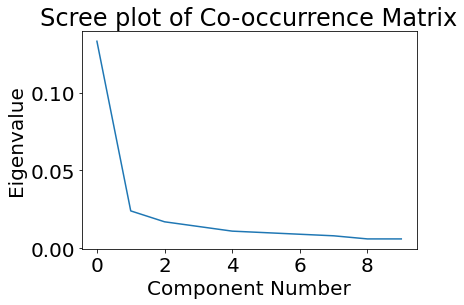

In [142]:
# scree_plot(pav_d)
scree_plot(our_d)
new_P = our_p[:, :6]
# ADd this to the report> Show that the first dimension captures the majority of the variance, but we can take up to the 6 

In [235]:
# ppmi = pmi(cooc_matrix_np)
# cooc_matrix_np = cooc_matrix.to_numpy()
# print(cooc_matrix.shape)
# P, D, Q = np.linalg.svd(ppmi, full_matrices=False)

/u/jai/miniconda3/envs/venv37/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  


In [143]:
def mds_visualization_2(data, labels, feature, delegate):
    plt.rcParams.update({"font.size": 20})
    embedding = MDS(n_components=2, random_state=42)
    F_lowdim = embedding.fit_transform(data)
    print(F_lowdim.shape)
    fig = plt.figure(figsize=(20, 10))
    low_val = np.array([idx for idx, label in enumerate(labels) if delegate(label, "1", feature)]).astype(int)
    high_val = np.array([idx for idx, label in enumerate(labels) if delegate(label, "2", feature)]).astype(int)
    plt.plot(F_lowdim[low_val, 0], F_lowdim[low_val, 1], "bo", markersize=12, label=f"Low {feature}")
    plt.plot(F_lowdim[high_val, 0], F_lowdim[high_val, 1], "gs", markersize=12, label=f"High {feature}")
    plt.legend()
    for i in range(len(F_lowdim)):
        plt.text(F_lowdim[i,0]*1.05, F_lowdim[i,1]*1.01, labels[i],fontsize=17)

    plt.xlabel('Dimension 1')    
    plt.ylabel('Dimension 2')
    plt.title(f"MDS Plot of Semantic Situation Space ({feature})")



In [144]:
def mds_visualization_3(data, labels, feature, delegate):
    plt.rcParams.update({"font.size": 20})
    embedding = MDS(n_components=2, random_state=42)
    F_lowdim = embedding.fit_transform(data)
    print(F_lowdim.shape)
    fig = plt.figure(figsize=(20, 10))
    low_val = np.array([idx for idx, label in enumerate(labels) if delegate(label, "1", feature)]).astype(int)
    mid_val = np.array([idx for idx, label in enumerate(labels) if delegate(label, "2", feature)]).astype(int)
    high_val = np.array([idx for idx, label in enumerate(labels) if delegate(label, "3", feature)]).astype(int)
    plt.plot(F_lowdim[low_val, 0], F_lowdim[low_val, 1], "bo", markersize=12, label=f"Low {feature}")
    plt.plot(F_lowdim[mid_val, 0], F_lowdim[mid_val, 1], "rx", markersize=12, label=f"Mid {feature}")
    plt.plot(F_lowdim[high_val, 0], F_lowdim[high_val, 1], "gs", markersize=12, label=f"High {feature}")
    plt.legend()
    # for i in range(len(F_lowdim)):
    #     plt.text(F_lowdim[i,0]*1.05, F_lowdim[i,1]*1.01, labels[i],fontsize=17)

    plt.xlabel('Dimension 1')    
    plt.ylabel('Dimension 2')
    plt.title(f"MDS Plot of Semantic Situation Space ({feature})")
    plt.show()



In [145]:
def mds_visualization_4(data, labels, feature, delegate):
    plt.rcParams.update({"font.size": 20})
    embedding = MDS(n_components=2, random_state=42)
    F_lowdim = embedding.fit_transform(data)
    print(F_lowdim.shape)
    fig = plt.figure(figsize=(20, 10))
    low_val = np.array([idx for idx, label in enumerate(labels) if delegate(label, "1", feature)]).astype(int)
    midlow_val = np.array([idx for idx, label in enumerate(labels) if delegate(label, "2", feature)]).astype(int)
    midhigh_val = np.array([idx for idx, label in enumerate(labels) if delegate(label, "3", feature)]).astype(int)
    high_val = np.array([idx for idx, label in enumerate(labels) if delegate(label, "4", feature)]).astype(int)
    plt.plot(F_lowdim[low_val, 0], F_lowdim[low_val, 1], "bo", markersize=12, label=f"Low {feature}")
    plt.plot(F_lowdim[midlow_val, 0], F_lowdim[midlow_val, 1], "ro", markersize=12, label=f"Mid-low {feature}")
    plt.plot(F_lowdim[midhigh_val, 0], F_lowdim[midhigh_val, 1], "ys", markersize=12, label=f"Mid-high {feature}")
    plt.plot(F_lowdim[high_val, 0], F_lowdim[high_val, 1], "gs", markersize=12, label=f"High {feature}")
    plt.legend()
    for i in range(len(F_lowdim)):
        plt.text(F_lowdim[i,0]*1.05, F_lowdim[i,1]*1.01, labels[i],fontsize=17)

    plt.xlabel('Dimension 1')    
    plt.ylabel('Dimension 2')
    plt.title(f"MDS Plot of Semantic Situation Space ({feature})")
    plt.show()



In [146]:
feature_to_index = {
    "Valence": 1,
    "Arousal": 3,
    "Dominance": 5,
    "Politeness": 7,
    "Formality": 9
}

In [147]:
original_dist_matrix = cosine_similarity(our_cooc)
derived_dist_matrix = cosine_similarity(new_P)
# original_dist_matrix = cdist(cooc_matrix_np, cooc_matrix_np)
# derived_dist_matrix = cdist(new_P, new_P)

/u/jai/miniconda3/envs/venv37/lib/python3.7/site-packages/sklearn/manifold/_mds.py:419: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn("The MDS API has changed. ``fit`` now constructs an"


(243, 2)


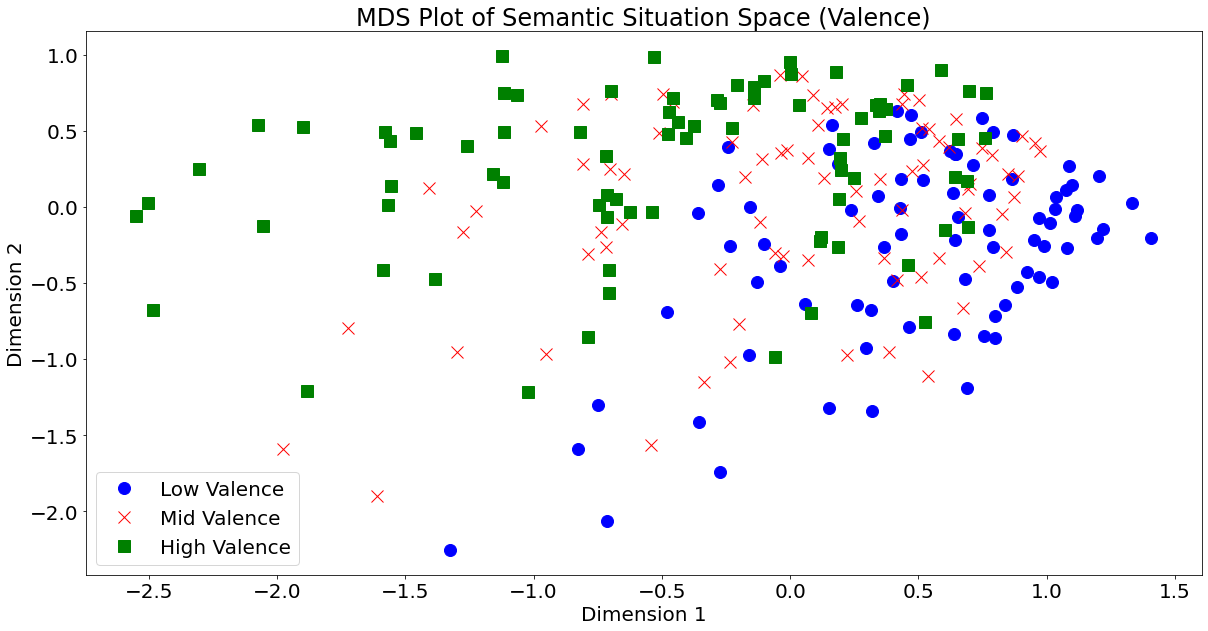

/u/jai/miniconda3/envs/venv37/lib/python3.7/site-packages/sklearn/manifold/_mds.py:419: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn("The MDS API has changed. ``fit`` now constructs an"


(243, 2)


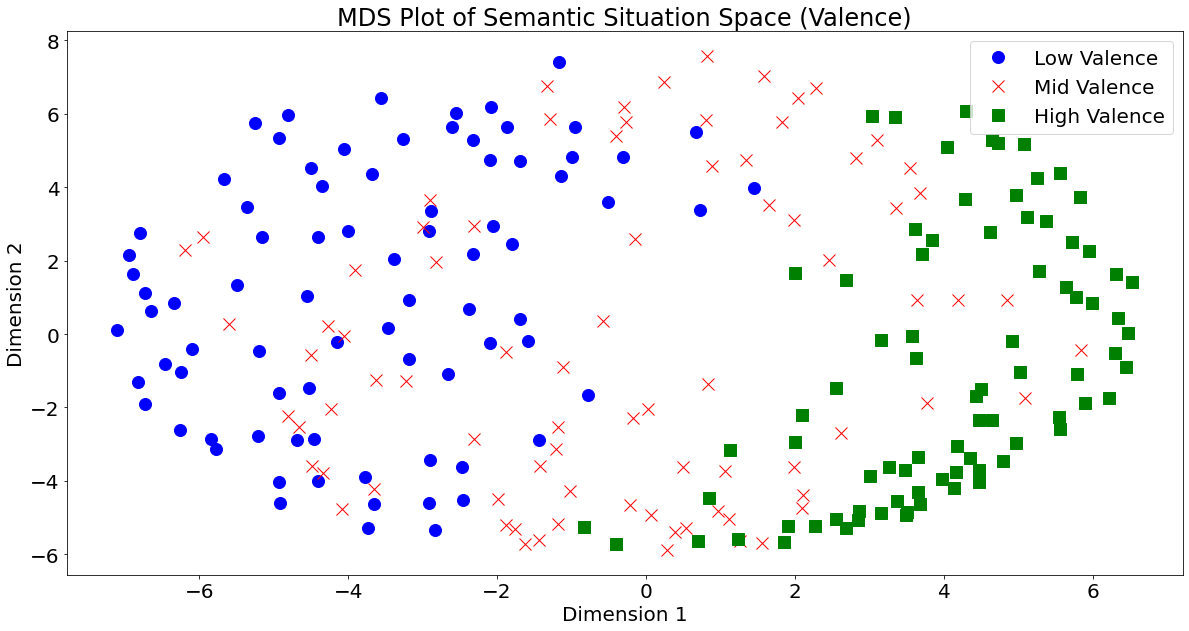

/u/jai/miniconda3/envs/venv37/lib/python3.7/site-packages/sklearn/manifold/_mds.py:419: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn("The MDS API has changed. ``fit`` now constructs an"


(243, 2)


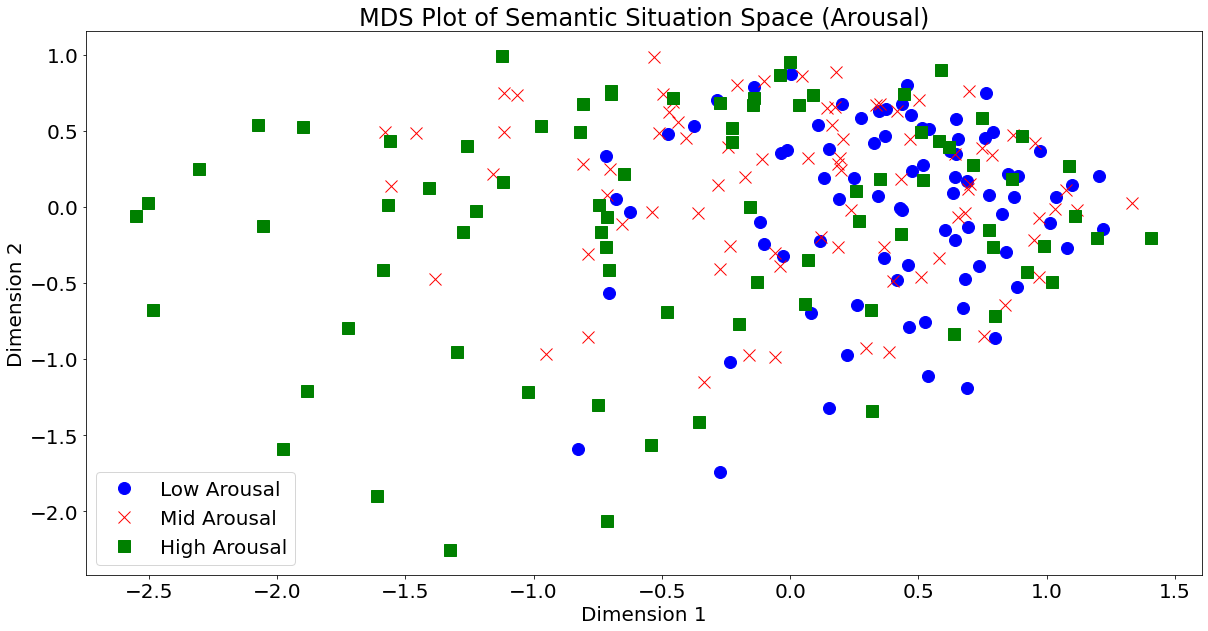

/u/jai/miniconda3/envs/venv37/lib/python3.7/site-packages/sklearn/manifold/_mds.py:419: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn("The MDS API has changed. ``fit`` now constructs an"


(243, 2)


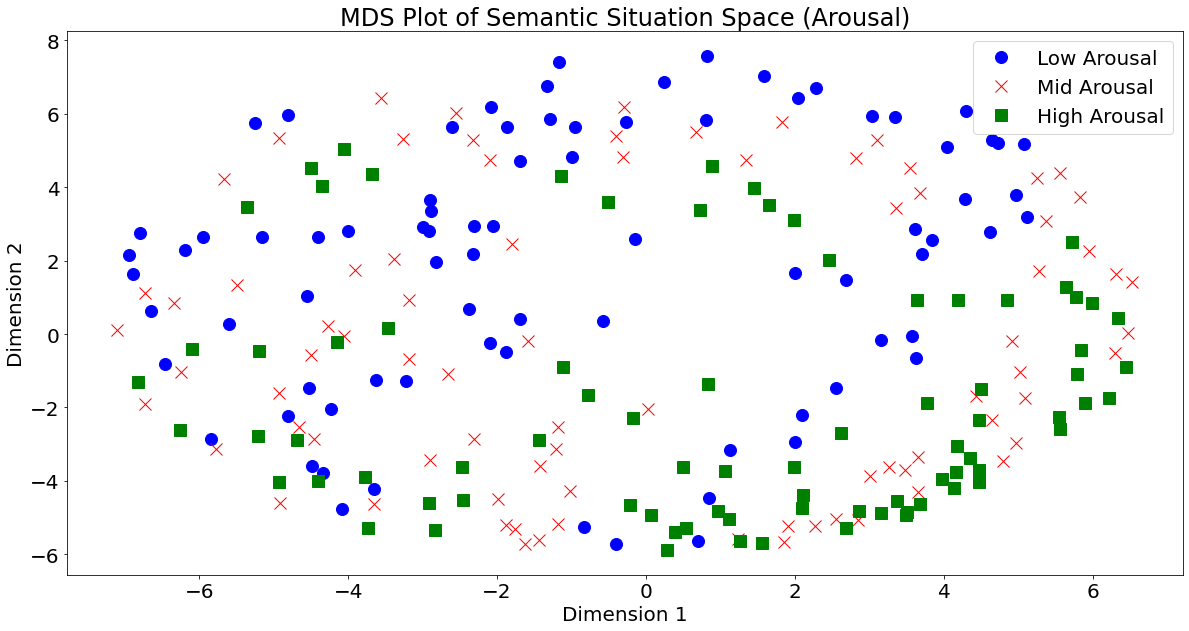

/u/jai/miniconda3/envs/venv37/lib/python3.7/site-packages/sklearn/manifold/_mds.py:419: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn("The MDS API has changed. ``fit`` now constructs an"


(243, 2)


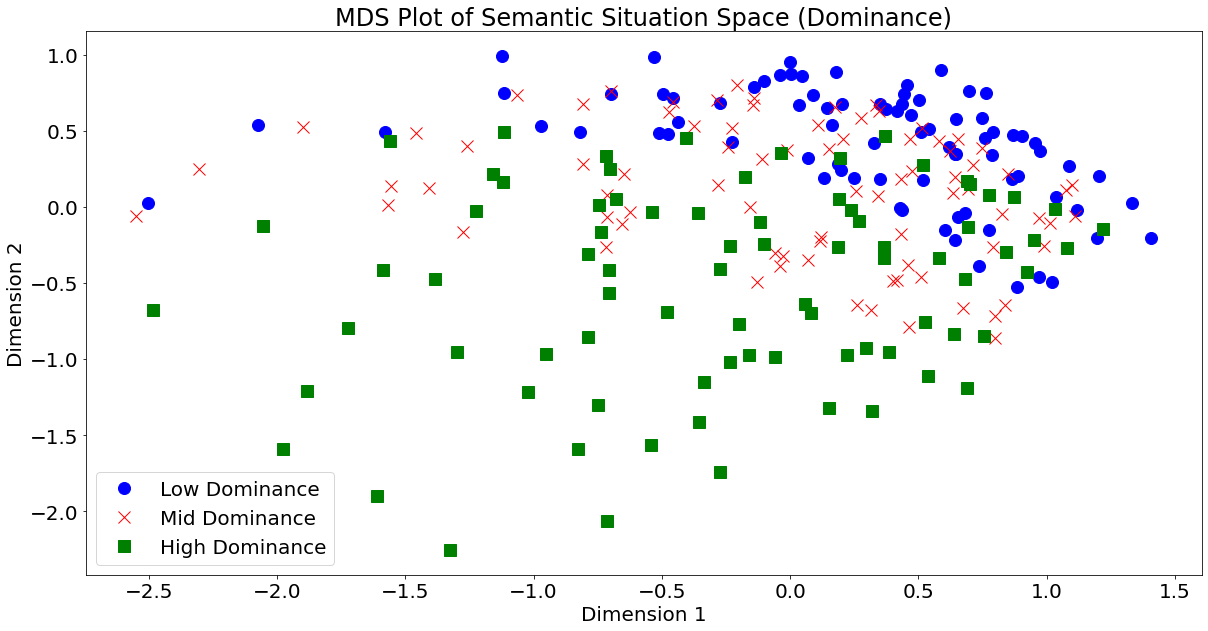

/u/jai/miniconda3/envs/venv37/lib/python3.7/site-packages/sklearn/manifold/_mds.py:419: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn("The MDS API has changed. ``fit`` now constructs an"


(243, 2)


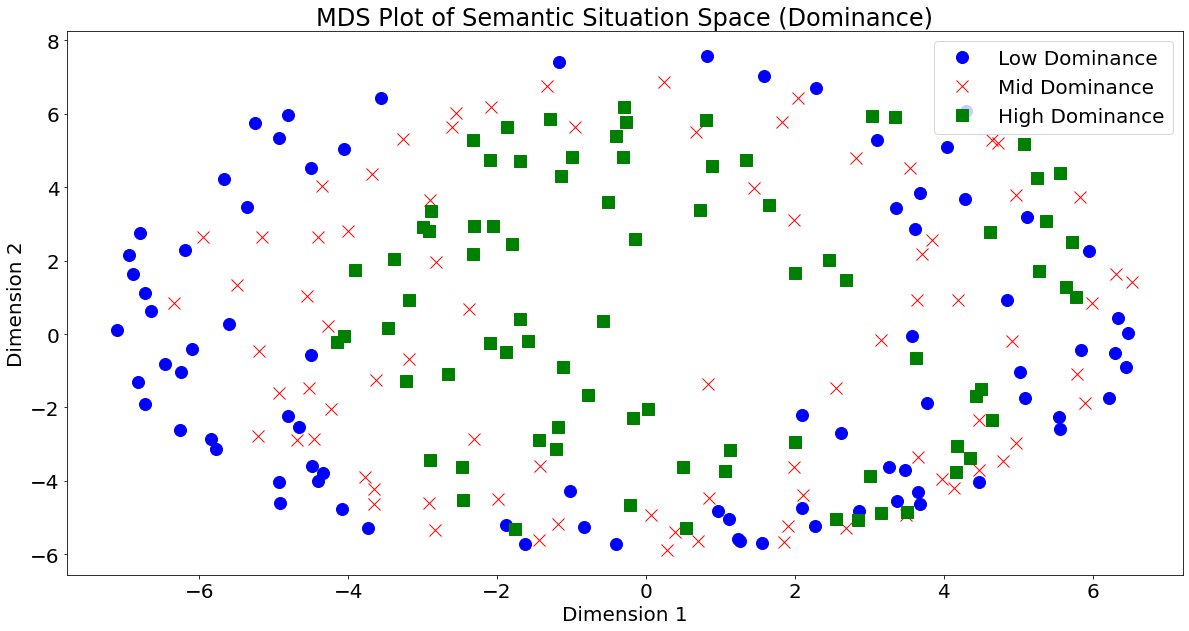

/u/jai/miniconda3/envs/venv37/lib/python3.7/site-packages/sklearn/manifold/_mds.py:419: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn("The MDS API has changed. ``fit`` now constructs an"


(243, 2)


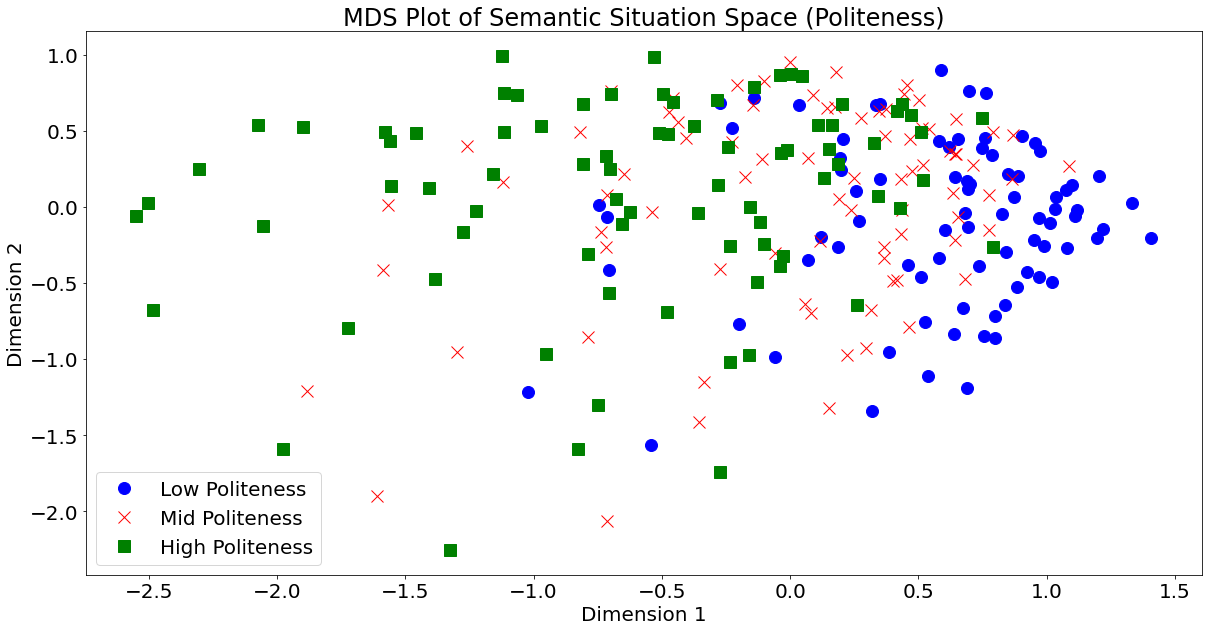

/u/jai/miniconda3/envs/venv37/lib/python3.7/site-packages/sklearn/manifold/_mds.py:419: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn("The MDS API has changed. ``fit`` now constructs an"


(243, 2)


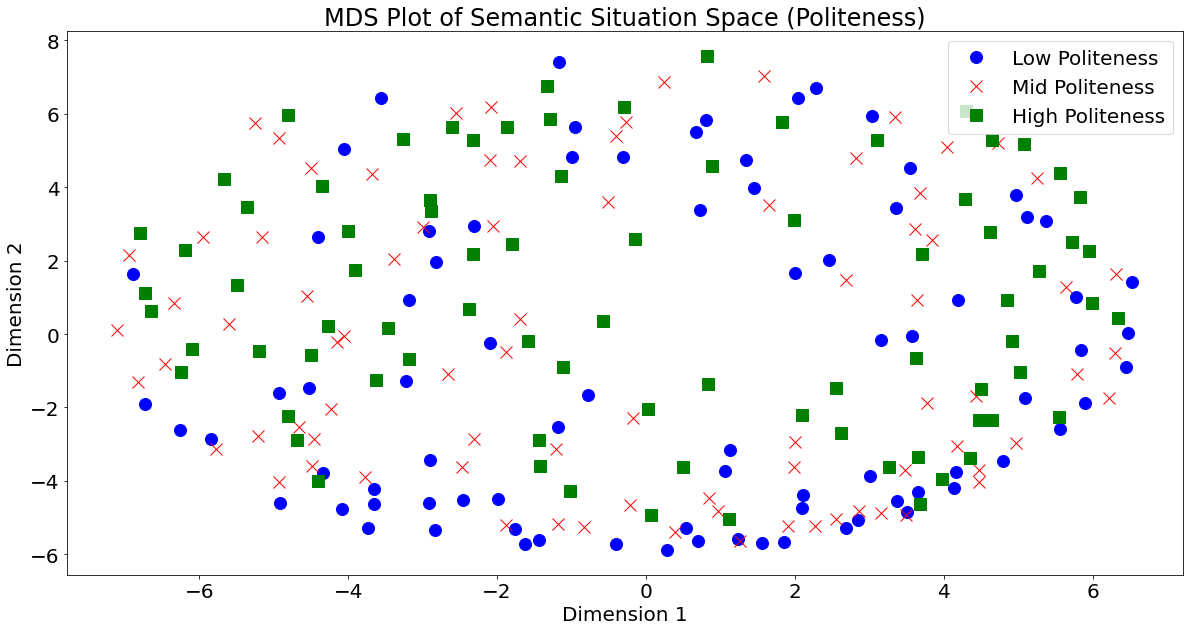

/u/jai/miniconda3/envs/venv37/lib/python3.7/site-packages/sklearn/manifold/_mds.py:419: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn("The MDS API has changed. ``fit`` now constructs an"


(243, 2)


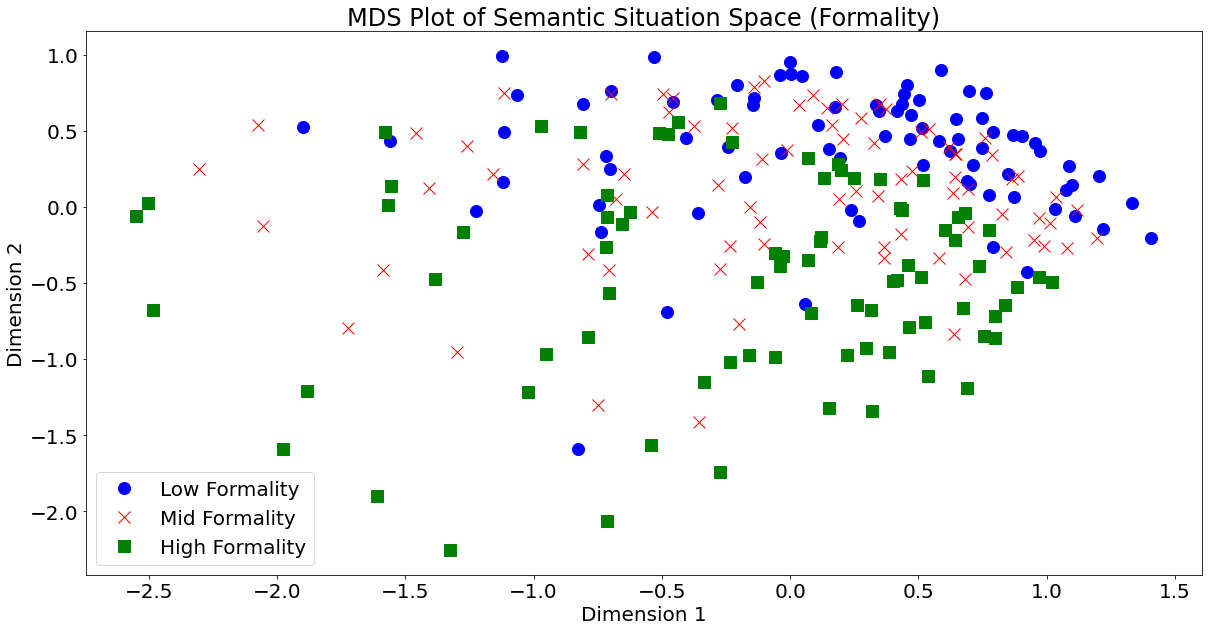

/u/jai/miniconda3/envs/venv37/lib/python3.7/site-packages/sklearn/manifold/_mds.py:419: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn("The MDS API has changed. ``fit`` now constructs an"


(243, 2)


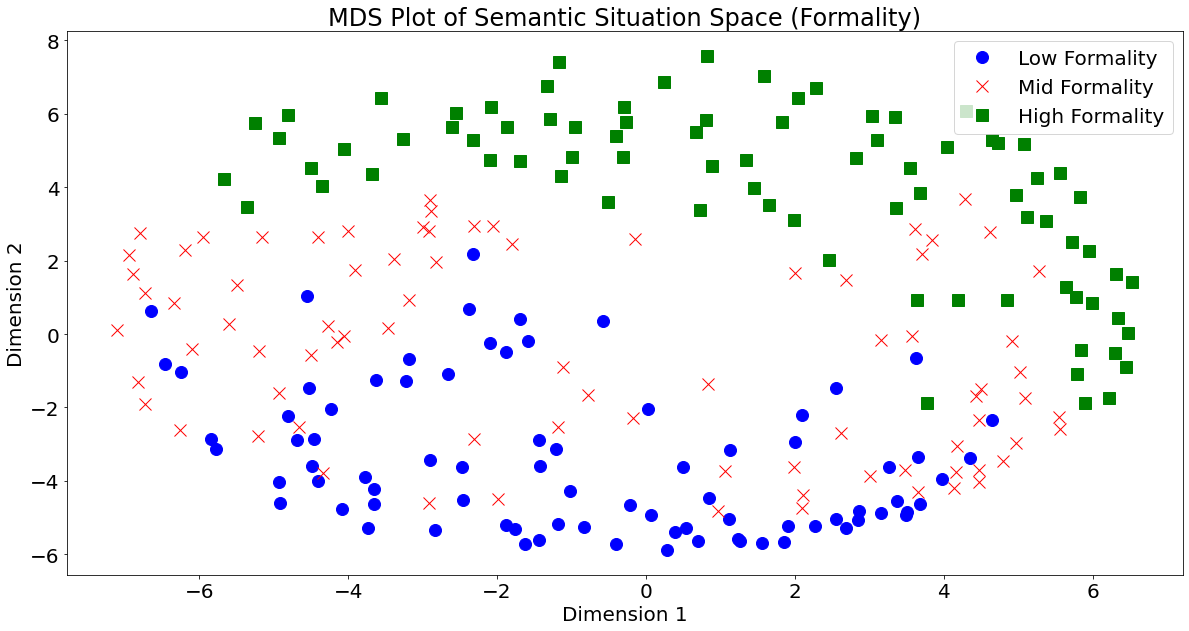

In [148]:
for feature in FEATURE_COLUMNS:
    mds_visualization_3(original_dist_matrix, cooc_matrix.index, feature, lambda x, y, z: x[feature_to_index[z]] == y)
    mds_visualization_3(derived_dist_matrix, cooc_matrix.index, feature, lambda x, y, z: x[feature_to_index[z]] == y)
